In [1]:
# What platform will the game be most popular on? 
# strategy: one hot encoding platform and genre, and use them as features to predict user_score
# the model takes one platform and multiple genres as input and chooses the platform with the highest user_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('../data/games_of_all_time.csv')
data.head()

,game_name,meta_score,user_score,platform,description,url,developer,genre,type,rating
0,The Legend of Zelda: Ocarina of Time,99.0,91.0,['nintendo-64'],"As a young boy, Link is tricked by Ganondorf, ...",https://www.metacritic.com/game/nintendo-64/th...,Nintendo,"['Action Adventure', 'Fantasy']",singleplayer,E
1,Super Mario Galaxy,97.0,91.0,['wii'],[Metacritic's 2007 Wii Game of the Year] The u...,https://www.metacritic.com/game/wii/super-mari...,Nintendo,"['Action', 'Platformer', '3D']",singleplayer,E
2,Super Mario Galaxy 2,97.0,91.0,['wii'],"Super Mario Galaxy 2, the sequel to the galaxy...",https://www.metacritic.com/game/wii/super-mari...,Nintendo EAD Tokyo,"['Action', 'Platformer', '3D']",singleplayer,E
3,Metroid Prime,97.0,89.0,['gamecube'],Samus returns in a new mission to unravel the ...,https://www.metacritic.com/game/gamecube/metro...,Retro Studios,"['Action', 'Shooter', 'First-Person', 'Sci-Fi']",singleplayer,T
4,Super Mario Odyssey,97.0,89.0,['switch'],New Evolution of Mario Sandbox-Style Gameplay....,https://www.metacritic.com/game/switch/super-m...,Nintendo,"['Action', 'Platformer', '3D']",singleplayer,E10+


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8831 entries, 0 to 8830
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   game_name    8831 non-null   object 
 1   meta_score   8831 non-null   float64
 2   user_score   8831 non-null   float64
 3   platform     8831 non-null   object 
 4   description  8831 non-null   object 
 5   url          8831 non-null   object 
 6   developer    8821 non-null   object 
 7   genre        8827 non-null   object 
 8   type         6727 non-null   object 
 9   rating       7691 non-null   object 
dtypes: float64(2), object(8)
memory usage: 690.0+ KB


In [3]:
data.isnull().sum()

game_name         0
meta_score        0
user_score        0
platform          0
description       0
url               0
developer        10
genre             4
type           2104
rating         1140
dtype: int64

In [4]:
df = data[['user_score', 'meta_score', 'platform', 'genre','type', 'rating']]
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5936 entries, 0 to 8830
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_score  5936 non-null   float64
 1   meta_score  5936 non-null   float64
 2   platform    5936 non-null   object 
 3   genre       5936 non-null   object 
 4   type        5936 non-null   object 
 5   rating      5936 non-null   object 
dtypes: float64(2), object(4)
memory usage: 324.6+ KB


<AxesSubplot:xlabel='type', ylabel='count'>

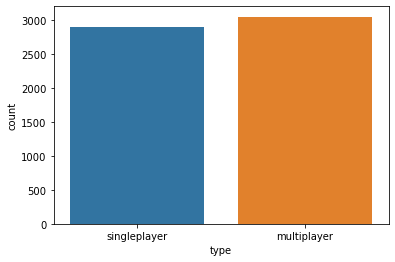

In [5]:
sns.countplot(x='type',data=df)

<AxesSubplot:xlabel='rating', ylabel='count'>

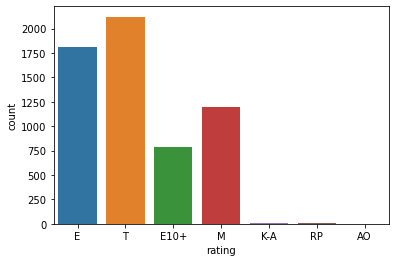

In [6]:
sns.countplot(x='rating',data=df)

In [7]:
import ast
from sklearn.preprocessing import MultiLabelBinarizer

In [8]:
p = df['platform'].map(ast.literal_eval)
g = df['genre'].map(ast.literal_eval)
mlb = MultiLabelBinarizer()

p_mlb = pd.DataFrame(mlb.fit_transform(p), columns=mlb.classes_, index=df.index)
g_mlb = pd.DataFrame(mlb.fit_transform(g), columns=mlb.classes_, index=df.index)
p_mlb = p_mlb.add_prefix('platform_')
g_mlb = g_mlb.add_prefix('genre_')
print(p_mlb)
print(g_mlb)

      platform_3ds  platform_dreamcast  platform_ds  \
0                0                   0            0   
1                0                   0            0   
2                0                   0            0   
3                0                   0            0   
4                0                   0            0   
...            ...                 ...          ...   
8825             0                   0            0   
8826             0                   0            0   
8827             0                   0            0   
8828             0                   0            0   
8830             0                   0            0   

      platform_game-boy-advance  platform_gamecube  platform_nintendo-64  \
0                             0                  0                     1   
1                             0                  0                     0   
2                             0                  0                     0   
3                             0    

In [9]:
df = df.drop('platform', axis=1)
df = df.drop('genre', axis=1)
df = pd.concat([df, p_mlb, g_mlb], 1)
df

,user_score,meta_score,type,rating,platform_3ds,platform_dreamcast,platform_ds,platform_game-boy-advance,platform_gamecube,platform_nintendo-64,...,genre_Virtual,genre_Virtual Life,genre_Visual Novel,genre_Volleyball,genre_WWI,genre_WWII,genre_Wakeboarding,genre_Wargame,genre_Western-Style,genre_Wrestling
0,91.0,99.0,singleplayer,E,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,91.0,97.0,singleplayer,E,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,91.0,97.0,singleplayer,E,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,89.0,97.0,singleplayer,T,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,89.0,97.0,singleplayer,E10+,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8825,83.0,85.0,singleplayer,T,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8826,80.5,74.0,singleplayer,T,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8827,76.0,69.0,singleplayer,E10+,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8828,73.0,70.0,multiplayer,E,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df['type']

0       singleplayer
1       singleplayer
2       singleplayer
3       singleplayer
4       singleplayer
            ...     
8825    singleplayer
8826    singleplayer
8827    singleplayer
8828     multiplayer
8830    singleplayer
Name: type, Length: 5936, dtype: object

In [11]:
df = pd.get_dummies(df, columns=['type'],drop_first=True)
df=pd.get_dummies(df, columns=['rating'])
df

,user_score,meta_score,platform_3ds,platform_dreamcast,platform_ds,platform_game-boy-advance,platform_gamecube,platform_nintendo-64,platform_pc,platform_playstation,...,genre_Western-Style,genre_Wrestling,type_singleplayer,rating_AO,rating_E,rating_E10+,rating_K-A,rating_M,rating_RP,rating_T
0,91.0,99.0,0,0,0,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
1,91.0,97.0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,91.0,97.0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
3,89.0,97.0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,89.0,97.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8825,83.0,85.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
8826,80.5,74.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
8827,76.0,69.0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0
8828,73.0,70.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [16]:
from sklearn.model_selection import train_test_split

X = df.drop(['user_score', 'meta_score'],axis=1).values
y = df['user_score'].values

print(x.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5936 entries, 0 to 8830
Columns: 196 entries, platform_3ds to rating_T
dtypes: int64(188), uint8(8)
memory usage: 8.7 MB
None


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm

In [25]:
model = Sequential()

model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [26]:
model.fit(x=X_train,
          y=y_train,
          validation_data=(X_test,y_test),
          batch_size=128,
          epochs=400)

Epoch 1/400
38/38 [==============================] - 0s 3ms/step - loss: 5105.9780 - val_loss: 4891.0293
Epoch 2/400
38/38 [==============================] - 0s 1ms/step - loss: 4044.2590 - val_loss: 2372.2319
Epoch 3/400
38/38 [==============================] - 0s 1ms/step - loss: 861.5822 - val_loss: 352.9490
Epoch 4/400
38/38 [==============================] - 0s 1ms/step - loss: 290.4853 - val_loss: 261.8695
Epoch 5/400
38/38 [==============================] - 0s 1ms/step - loss: 247.4366 - val_loss: 233.1722
Epoch 6/400
38/38 [==============================] - 0s 2ms/step - loss: 227.4576 - val_loss: 217.1232
Epoch 7/400
38/38 [==============================] - 0s 1ms/step - loss: 214.1089 - val_loss: 204.4659
Epoch 8/400
38/38 [==============================] - 0s 1ms/step - loss: 204.8531 - val_loss: 196.5788
Epoch 9/400
38/38 [==============================] - 0s 1ms/step - loss: 197.1845 - val_loss: 190.2248
Epoch 10/400
38/38 [==============================] - 0s 1ms/step - l

Epoch 80/400
38/38 [==============================] - 0s 1ms/step - loss: 128.2268 - val_loss: 157.4897
Epoch 81/400
38/38 [==============================] - 0s 1ms/step - loss: 127.8531 - val_loss: 157.1164
Epoch 82/400
38/38 [==============================] - 0s 1ms/step - loss: 127.2628 - val_loss: 157.0443
Epoch 83/400
38/38 [==============================] - 0s 1ms/step - loss: 127.4911 - val_loss: 158.3692
Epoch 84/400
38/38 [==============================] - 0s 1ms/step - loss: 127.8849 - val_loss: 157.9155
Epoch 85/400
38/38 [==============================] - 0s 1ms/step - loss: 127.6046 - val_loss: 157.8235
Epoch 86/400
38/38 [==============================] - 0s 1ms/step - loss: 126.9064 - val_loss: 157.2216
Epoch 87/400
38/38 [==============================] - 0s 1ms/step - loss: 127.0535 - val_loss: 158.7911
Epoch 88/400
38/38 [==============================] - 0s 1ms/step - loss: 126.9673 - val_loss: 157.9452
Epoch 89/400
38/38 [==============================] - 0s 1ms/ste

38/38 [==============================] - 0s 1ms/step - loss: 120.5317 - val_loss: 161.2101
Epoch 159/400
38/38 [==============================] - 0s 2ms/step - loss: 119.8404 - val_loss: 163.3811
Epoch 160/400
38/38 [==============================] - 0s 1ms/step - loss: 119.3322 - val_loss: 160.0452
Epoch 161/400
38/38 [==============================] - 0s 1ms/step - loss: 119.4867 - val_loss: 161.0309
Epoch 162/400
38/38 [==============================] - 0s 1ms/step - loss: 120.2060 - val_loss: 162.0513
Epoch 163/400
38/38 [==============================] - 0s 1ms/step - loss: 119.2256 - val_loss: 162.4374
Epoch 164/400
38/38 [==============================] - 0s 1ms/step - loss: 119.4793 - val_loss: 161.9677
Epoch 165/400
38/38 [==============================] - 0s 2ms/step - loss: 118.4171 - val_loss: 163.1968
Epoch 166/400
38/38 [==============================] - 0s 2ms/step - loss: 119.2512 - val_loss: 162.3875
Epoch 167/400
38/38 [==============================] - 0s 2ms/step - 

38/38 [==============================] - 0s 1ms/step - loss: 113.4794 - val_loss: 169.7072
Epoch 237/400
38/38 [==============================] - 0s 1ms/step - loss: 113.8058 - val_loss: 169.2995
Epoch 238/400
38/38 [==============================] - 0s 1ms/step - loss: 113.5290 - val_loss: 168.5151
Epoch 239/400
38/38 [==============================] - 0s 1ms/step - loss: 113.3496 - val_loss: 170.5066
Epoch 240/400
38/38 [==============================] - 0s 1ms/step - loss: 113.1048 - val_loss: 168.4432
Epoch 241/400
38/38 [==============================] - 0s 1ms/step - loss: 113.7637 - val_loss: 169.3150
Epoch 242/400
38/38 [==============================] - 0s 1ms/step - loss: 113.2131 - val_loss: 170.0247
Epoch 243/400
38/38 [==============================] - 0s 1ms/step - loss: 113.3175 - val_loss: 174.8829
Epoch 244/400
38/38 [==============================] - 0s 1ms/step - loss: 113.2671 - val_loss: 169.1653
Epoch 245/400
38/38 [==============================] - 0s 1ms/step - 

38/38 [==============================] - 0s 2ms/step - loss: 106.7205 - val_loss: 175.4165
Epoch 315/400
38/38 [==============================] - 0s 2ms/step - loss: 107.0688 - val_loss: 180.8126
Epoch 316/400
38/38 [==============================] - 0s 2ms/step - loss: 107.7884 - val_loss: 175.7822
Epoch 317/400
38/38 [==============================] - 0s 2ms/step - loss: 106.4556 - val_loss: 175.2316
Epoch 318/400
38/38 [==============================] - 0s 2ms/step - loss: 106.6580 - val_loss: 175.3748
Epoch 319/400
38/38 [==============================] - 0s 1ms/step - loss: 106.2283 - val_loss: 178.9146
Epoch 320/400
38/38 [==============================] - 0s 2ms/step - loss: 107.9080 - val_loss: 174.7398
Epoch 321/400
38/38 [==============================] - 0s 2ms/step - loss: 106.3714 - val_loss: 174.9767
Epoch 322/400
38/38 [==============================] - 0s 1ms/step - loss: 106.3956 - val_loss: 176.5156
Epoch 323/400
38/38 [==============================] - 0s 1ms/step - 

38/38 [==============================] - 0s 1ms/step - loss: 101.0004 - val_loss: 179.2194
Epoch 393/400
38/38 [==============================] - 0s 1ms/step - loss: 101.2108 - val_loss: 181.9652
Epoch 394/400
38/38 [==============================] - 0s 1ms/step - loss: 100.5116 - val_loss: 180.1733
Epoch 395/400
38/38 [==============================] - 0s 1ms/step - loss: 100.8258 - val_loss: 181.7519
Epoch 396/400
38/38 [==============================] - 0s 1ms/step - loss: 100.9147 - val_loss: 179.8774
Epoch 397/400
38/38 [==============================] - 0s 1ms/step - loss: 100.8049 - val_loss: 181.7487
Epoch 398/400
38/38 [==============================] - 0s 1ms/step - loss: 100.3585 - val_loss: 180.3236
Epoch 399/400
38/38 [==============================] - 0s 1ms/step - loss: 100.1933 - val_loss: 181.6381
Epoch 400/400
38/38 [==============================] - 0s 1ms/step - loss: 100.4948 - val_loss: 183.2943


In [27]:
from tensorflow.keras.models import load_model

In [28]:
model.save('evan_model.h5')  

In [29]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

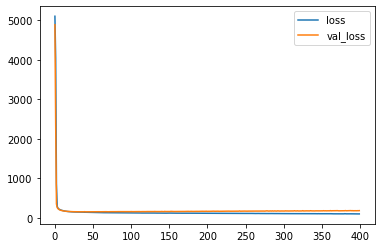

In [30]:
losses[['loss','val_loss']].plot()

In [31]:
X_test

array([[0, 0, 1, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [52]:
predictions = model.predict(X_test)
predictions

array([[55.616966],
       [77.06463 ],
       [66.48389 ],
       ...,
       [64.33152 ],
       [72.333786],
       [71.582825]], dtype=float32)

In [48]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

In [49]:
mean_absolute_error(y_test,predictions)

10.414196173671119

In [50]:
np.sqrt(mean_squared_error(y_test,predictions))

13.538621342851258

In [51]:
explained_variance_score(y_test,predictions)

-0.10723466516908498

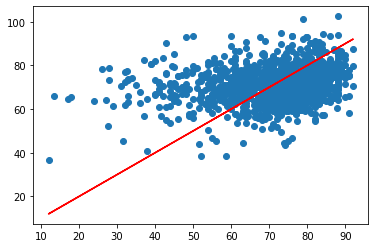

In [35]:
plt.scatter(y_test,predictions)
plt.plot(y_test,y_test,'r')

In [43]:
p_shape = predictions.shape
p_shape

(1188, 1)

In [44]:
errors = y_test.reshape(p_shape[0], p_shape[1]) - predictions

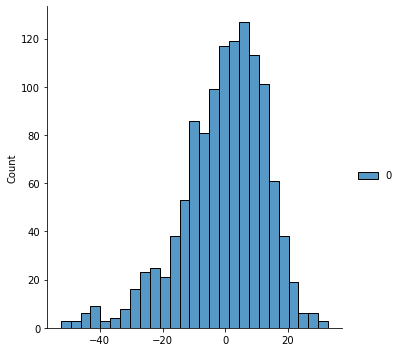

In [47]:
sns.displot(errors)